In [51]:
import pickle as pkl
import os
from graph_tool.draw import sfdp_layout
from matplotlib import pyplot as plt

from helpers import makedir_if_not_there
from graph_helpers import load_graph_by_name
from viz_helpers import lattice_node_pos, query_plot_setting, visualize, default_plot_setting

In [3]:
graph_name = 'lattice-100'
g = load_graph_by_name(graph_name, suffix='_weighted_0.5')

load graph from data/lattice-100/graph_weighted_0.5.gt


In [41]:
if graph_name == 'lattice-100':
    pos = lattice_node_pos(g, shape=(10, 10))
else:
    pos = sfdp_layout(g)

In [46]:
round_id = 64
cascade_size = 0.25
obs_fraction = 0.25
cascade_model = 'si'
sampling_method = 'simulation'

In [42]:
n_queries_to_show = 10

In [47]:
data_id = '{graph_name}-m{cascade_model}-s{cascade_size}-o{obs_fraction}-omuniform'.format(
    graph_name=graph_name,
    cascade_model=cascade_model,
    cascade_size=cascade_size,
    obs_fraction=obs_fraction
)

In [48]:
query_methods = ['random', 'pagerank', 'entropy', 'cond-entropy']
(obs, c) = pkl.load(
    open('cascade-weighted/{data_id}/{round_id}.pkl'.format(
        data_id=data_id, 
        round_id=round_id),
         'rb'))

queries_by_method = {}
for query_method in query_methods:
    queries_by_method[query_method] = pkl.load(
        open('outputs/queries-weighted/{data_id}/{sampling_method}/{query_method}/{round_id}.pkl'.format(
            data_id=data_id,
            sampling_method=sampling_method,
            query_method=query_method,
            round_id=round_id),
             'rb'))[0]
n_queries = len(queries_by_method['random'])    


saving to figs/query-process-illustration/lattice-100/lattice-100-msi-s0.25-o0.25-omuniform/64/cascade.pdf


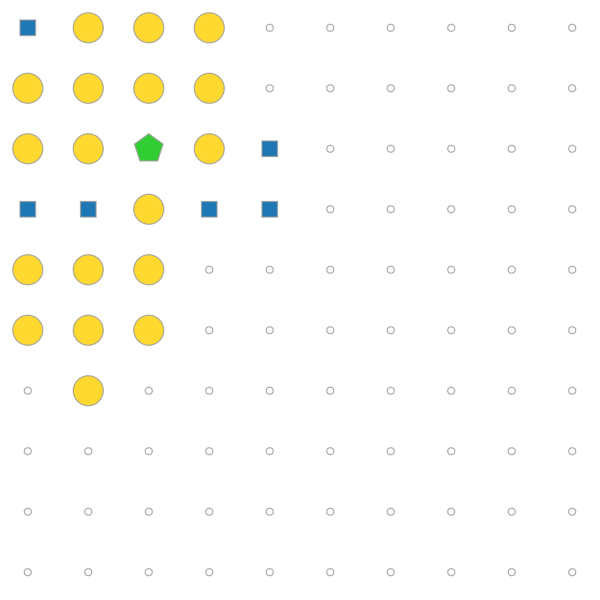

In [49]:
fig_dir = os.path.join(
    'figs/query-process-illustration',
    graph_name, data_id, str(round_id)
)
makedir_if_not_there(fig_dir)

setting = default_plot_setting(g, c, obs, size_multiplier=1.5)
visualize(g, pos, **setting, output=os.path.join(fig_dir, 'cascade.pdf'))

pagerank
saving to figs/query-process-illustration/lattice-100/lattice-100-msi-s0.25-o0.25-omuniform/64/pagerank.pdf


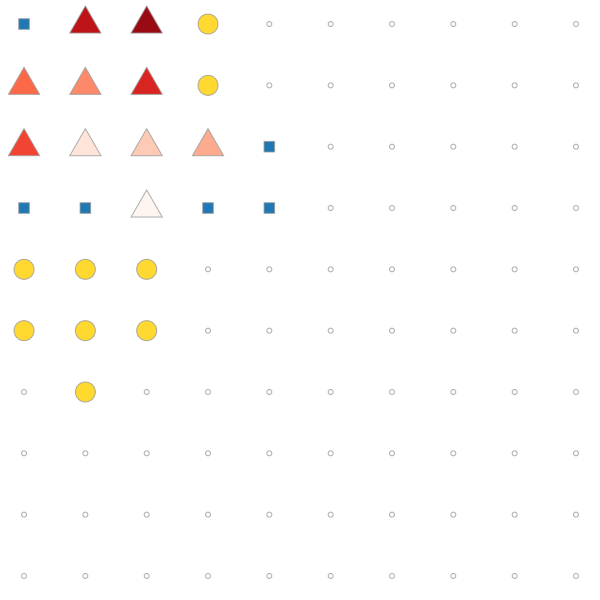

cond-entropy
saving to figs/query-process-illustration/lattice-100/lattice-100-msi-s0.25-o0.25-omuniform/64/cond-entropy.pdf


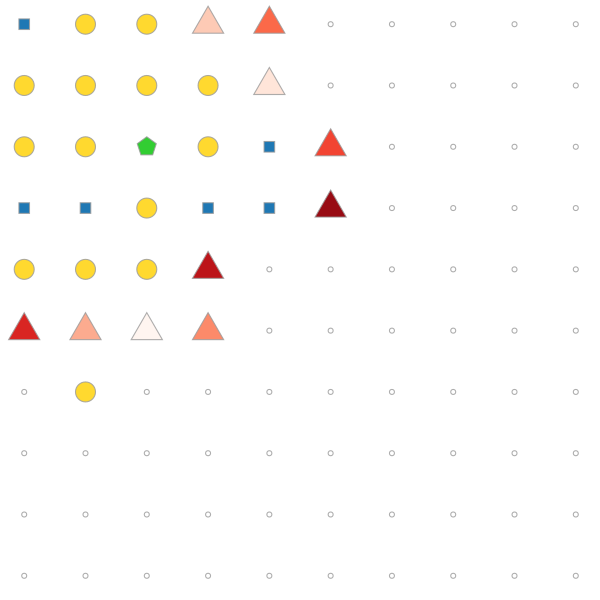

entropy
saving to figs/query-process-illustration/lattice-100/lattice-100-msi-s0.25-o0.25-omuniform/64/entropy.pdf


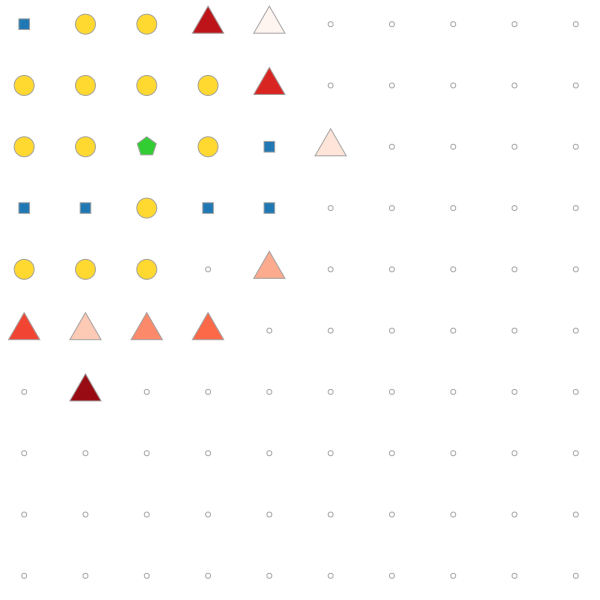

random
saving to figs/query-process-illustration/lattice-100/lattice-100-msi-s0.25-o0.25-omuniform/64/random.pdf


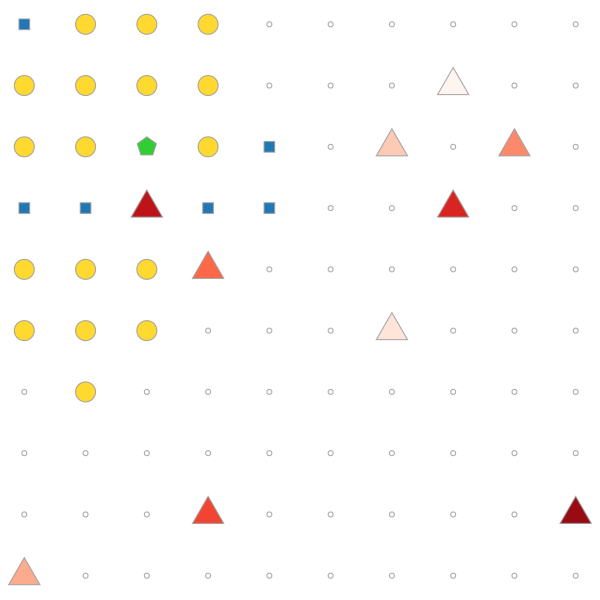

In [50]:
plt.switch_backend('cairo')

# for cls, params, name in stategies:
for name in queries_by_method:
    print(name)
    queries = queries_by_method[name][:n_queries_to_show]

    setting = query_plot_setting(
        g, c, obs, queries,
        node_size=36,
        indicator_type='color'
    )
    visualize(
        g,
        pos,
        **setting,
        output=os.path.join(fig_dir, '{}.pdf'.format(name)))